## Building a Digit Classifier with Fastai

In [1]:
from fastai.vision.all import *

#### Preparing the Data

In [2]:
# downloading and unpacking the files
path = untar_data(URLs.MNIST)

# setting the working path
Path.BASE_PATH = path

# inspect our directory
path.ls()

(#2) [Path('training'),Path('testing')]

In [3]:
# verify if we have all numbers
(path/'training').ls(), (path/'training'/'4').ls()

((#10) [Path('training/9'),Path('training/0'),Path('training/7'),Path('training/6'),Path('training/1'),Path('training/8'),Path('training/4'),Path('training/3'),Path('training/2'),Path('training/5')],
 (#5842) [Path('training/4/27980.png'),Path('training/4/30542.png'),Path('training/4/29007.png'),Path('training/4/11598.png'),Path('training/4/26334.png'),Path('training/4/37239.png'),Path('training/4/32341.png'),Path('training/4/17857.png'),Path('training/4/29761.png'),Path('training/4/36641.png')...])

In [4]:
# building a dictionary with all images
def load_images(folder):
    images = dict()
    for digit in range(10):
        images[digit] = [tensor(Image.open(f)) for f in (path/folder/str(digit)).ls()]
    return images

In [6]:
# load training and testing set
all_images = load_images('training')
testing_images = load_images('testing')

In [11]:
# split all images in training and validation set
training_images = dict()
validation_images = dict()
for digit in range(10):
    idx = math.floor(len(all_images[digit]) * .8)
    training_images[digit] = all_images[digit][:idx]
    validation_images[digit] = all_images[digit][idx:]

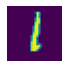

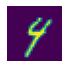

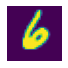

In [15]:
# lets inspect to samples
for sample in (training_images[1][3], validation_images[4][2], testing_images[6][2]):
    show_image(sample)

In [216]:
# create x and y tensors for all the sets
train_x, train_y, valid_x, valid_y, test_x, test_y = \
    tensor([]), tensor([]), tensor([]), tensor([]), tensor([]), tensor([])
for digit in range(10):
    # training set
    train_x = torch.cat([train_x, torch.stack(training_images[digit])])
    train_y = torch.cat([train_y, tensor([digit]*len(training_images[digit])).unsqueeze(1)])
    # validation set
    valid_x = torch.cat([valid_x, torch.stack(validation_images[digit])])
    valid_y = torch.cat([valid_y, tensor([digit]*len(validation_images[digit])).unsqueeze(1)])
    # testing set
    test_x = torch.cat([test_x, torch.stack(testing_images[digit])])
    test_y = torch.cat([test_y, tensor([digit]*len(testing_images[digit])).unsqueeze(1)])

In [217]:
train_x.shape, train_y.shape, valid_x.shape, valid_y.shape, test_x.shape, test_y.shape

(torch.Size([47995, 28, 28]),
 torch.Size([47995, 1]),
 torch.Size([12005, 28, 28]),
 torch.Size([12005, 1]),
 torch.Size([10000, 28, 28]),
 torch.Size([10000, 1]))

In [218]:
# because we don't want to keep any spatial information we just 
# reshape the matrix of images to a vector
train_x = train_x.view((-1, 28*28))
valid_x = valid_x.view((-1, 28*28))
test_x = test_x.view((-1, 28*28))
train_x.shape, valid_x.shape, test_x.shape

(torch.Size([47995, 784]), torch.Size([12005, 784]), torch.Size([10000, 784]))

In [219]:
# and our targes
train_y.shape, valid_y.shape, test_y.shape

(torch.Size([47995, 1]), torch.Size([12005, 1]), torch.Size([10000, 1]))

In [220]:
# for pytorch we need 1d target tensors
train_y[:3], train_y.ndim

(tensor([[0.],
         [0.],
         [0.]]),
 2)

In [221]:
# so we squeeze the dimentions
train_y = train_y.squeeze().long()
valid_y = valid_y.squeeze().long()
test_y = test_y.squeeze().long()

In [222]:
train_y[:3], train_y.ndim

(tensor([0, 0, 0]), 1)

In [223]:
train_x.shape, valid_x.shape, test_x.shape

(torch.Size([47995, 784]), torch.Size([12005, 784]), torch.Size([10000, 784]))

In [224]:
train_y.shape, valid_y.shape, test_y.shape

(torch.Size([47995]), torch.Size([12005]), torch.Size([10000]))

In [371]:
# create data set and dataloaders 
ds_train = list(zip(train_x, train_y))
ds_valid = list(zip(valid_x, valid_y))

dl_train = DataLoader(ds_train, batch_size=256, shuffle=True)
dl_valid = DataLoader(ds_valid, batch_size=256, shuffle=True)

In [372]:
# and the combined loader
dls = DataLoaders(dl_train, dl_valid)

#### Create a Simple Dense Connected Network

In [390]:
# instantiate network
simple_net = nn.Sequential(
    nn.Linear(28*28, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 10)
)

In [391]:
learn = Learner(dls, simple_net, opt_func=SGD,
               loss_func=F.cross_entropy, metrics=accuracy)

In [392]:
# and do some training
learn.fit(20, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.617183,0.525861,0.849146,00:00
1,0.396907,0.401134,0.888880,00:00
2,0.324397,0.354383,0.899875,00:00
3,0.285383,0.324180,0.909788,00:00
4,0.263043,0.291199,0.919783,00:00
5,0.237446,0.277928,0.922199,00:00
6,0.229118,0.262656,0.928613,00:00
7,0.210963,0.253100,0.929696,00:00
8,0.196862,0.244270,0.933278,00:00
9,0.180682,0.235868,0.934444,00:00


tensor(0)

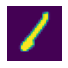

In [426]:
# checking on a random sample
show_image(test_x[1200].view((28, 28))); test_y[0]

In [427]:
result = simple_net.forward(test_x[1200])
result.argmax()

tensor(1)

In [435]:
# calculating validation on the test set by hand
corrects = np.array([])
for i, target in zip(test_x, test_y):
    pred_label = simple_net.forward(i).argmax()
    corrects = np.append(corrects, pred_label==target)

In [436]:
test_x.shape, corrects.shape

(torch.Size([10000, 784]), (10000,))

In [439]:
# check result
print(f'Accuracy on the testset: {corrects.mean()*100}%')

Accuracy on the testset: 94.98%


#### Creating a Locally Connected Network

In [443]:
# creating loader
image_data_loader = ImageDataLoaders.from_folder(path, train='training', valid='testing')

In [445]:
# instantiating learner with resnet architecture
learn = cnn_learner(image_data_loader, resnet18, pretrained=False,
                    loss_func=F.cross_entropy, metrics=accuracy)

In [446]:
# fine tuning for one cycle
learn.fit_one_cycle(1, 0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.084031,0.649272,0.986800,13:10


As expected locally connected layers yield much better results.